<img src="images/knn.png" alt="drawing" width="1000"/>

# **K Nearest Neighbors**

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.pipeline import Pipeline

In [23]:
genes = pd.read_csv("data/gene_expression.csv")
genes.head()

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


## Data Analysis

The data measurements have an accuracy up to one decimal point, which is why some patients have the same *Gene One* and *Gene Two* combinations, this can be seen from the semi-transparent scatter plot

In [24]:
genes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gene One        3000 non-null   float64
 1   Gene Two        3000 non-null   float64
 2   Cancer Present  3000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 70.4 KB


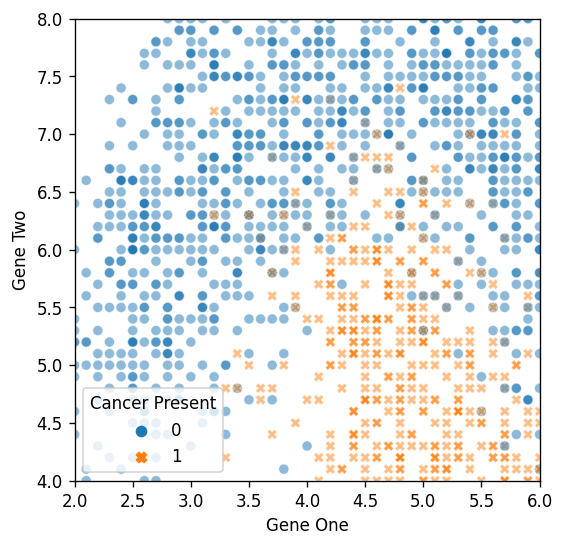

In [25]:
plt.figure(figsize=(5,5), dpi=120)
sns.scatterplot(data=genes, x='Gene One', y='Gene Two', hue='Cancer Present', style='Cancer Present', alpha=0.5)

plt.xlim(2, 6)
plt.ylim(4, 8)

plt.show()


<Figure size 2000x2000 with 0 Axes>

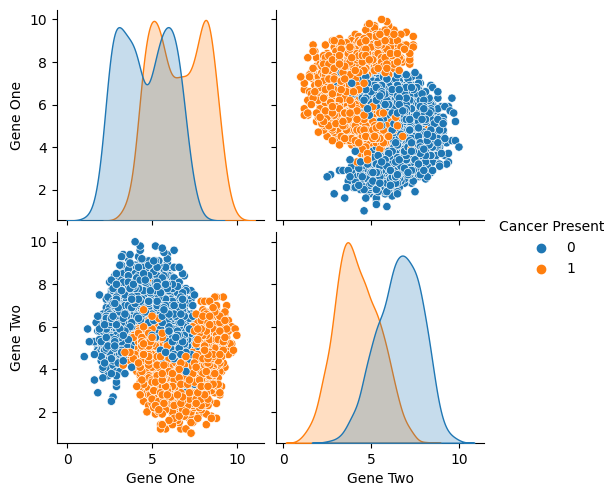

In [26]:
plt.figure(figsize=(10, 10), dpi=200)
sns.pairplot(data=genes, hue='Cancer Present')

## KNN Model

In [27]:
label = 'Cancer Present'

X = genes.drop(label, axis='columns')
y = genes[label]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=1)

In [30]:
y_pred = model.predict(X_test_scaled)

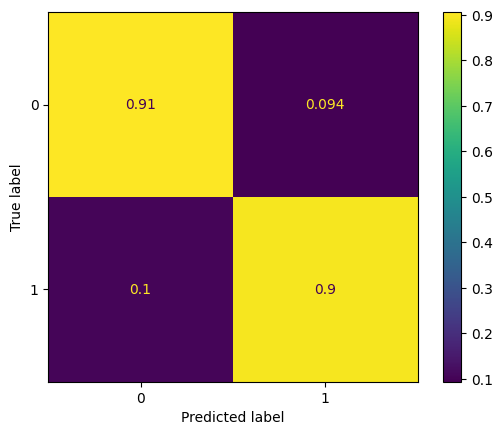

In [31]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       470
           1       0.90      0.90      0.90       430

    accuracy                           0.90       900
   macro avg       0.90      0.90      0.90       900
weighted avg       0.90      0.90      0.90       900



### Choosing K

#### Elbow Method

From the *Elbow Method* we can use visual inspection of the Test Error Rates in order to determine a good choice for $K$. In this case we might choose $K=14$

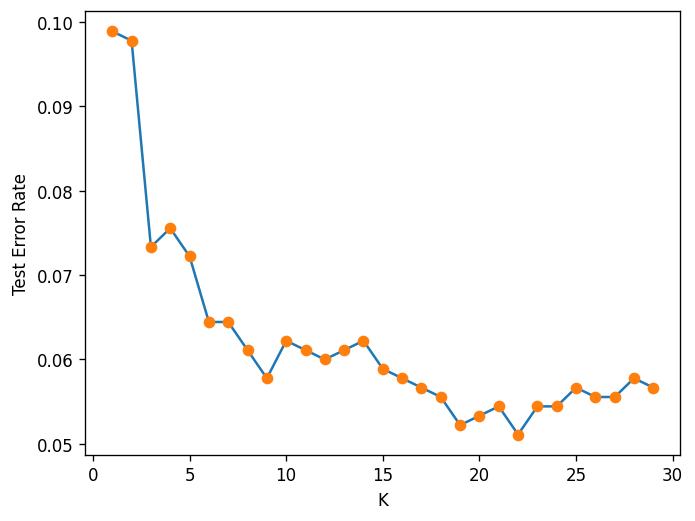

In [33]:
test_error_rates = []

for k in range(1, 30):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    
    test_error = 1 - accuracy_score(y_test, y_pred)
    test_error_rates.append(test_error)  
    
plt.figure(dpi=120)
plt.plot(range(1, 30), test_error_rates)
plt.plot(range(1, 30), test_error_rates, 'o')

plt.xlabel('K')
plt.ylabel('Test Error Rate')
plt.show()

In [34]:
model = KNeighborsClassifier(n_neighbors=14)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       470
           1       0.95      0.92      0.93       430

    accuracy                           0.94       900
   macro avg       0.94      0.94      0.94       900
weighted avg       0.94      0.94      0.94       900



#### Grid Search Cross-Validation using a Pipeline

set up a scaler and model

In [35]:
scaler = StandardScaler()
knn = KNeighborsClassifier()
# knn.get_params().keys()

the <code>steps</code> are the operations that are being carried out in the form of a list of tuples. Each tuple has the string handle (used for referencing) and the object used in the pipeline, in this case first the scaler, and then the model.

In [36]:
steps = [('scaler', scaler), ('knn', knn)]
pipe = Pipeline(steps)

Similar to a regular GridSearch the parameter grid <code>param_grid</code> is defined

The keys of this param grid have to be formatted in a particular way. 

key = [string_handle + __ + parameter_name]

The string handle has to correspond to the string handle of the object/class in the <code>steps</code>, the <code>parameter_name</code> has to correspond to a valid argument for initiating said object/class

In [37]:
k_values = list(range(1, 20))
param_grid = {'knn__n_neighbors': k_values}

Execute <code>GridSearchCV</code> with the <code>Pipeline</code> object

In [38]:
full_cv_classifier = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
full_cv_classifier.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19]},
             scoring='accuracy')

The GridSearchCV class returns an optimal value of $K = 16$

In [39]:
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=16))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=16),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 16,
 'knn__p': 2,
 'knn__weights': 'uniform'}

Resulting in better F1-Scores

In [40]:
y_pred = full_cv_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       470
           1       0.95      0.93      0.94       430

    accuracy                           0.94       900
   macro avg       0.94      0.94      0.94       900
weighted avg       0.94      0.94      0.94       900



#### New Prediction

We can use the finalized model to predict whether a patient has cancer or not

In [41]:
new_patient = pd.DataFrame({'Gene One': [3.8], 'Gene Two': [6.4]})
print(f"Cancer Present = {list(full_cv_classifier.predict(new_patient))[0]}")
print(f"Probability = {full_cv_classifier.predict_proba(new_patient)[0][0] * 100}%")


Cancer Present = 0
Probability = 100.0%


Looking at the scatter plot, it can be seen that the patient is well into the blue area, but there are still some yellow orange crosses nearby. The model claims to be 100% certain, which must mean the $K = 16$ nearest neighbors must all be blue dots. Even though there are orange dots near by it could mean that there are a lot of patients with a 3.8, 6.4 gene combinations (resulting in a distance of 0)

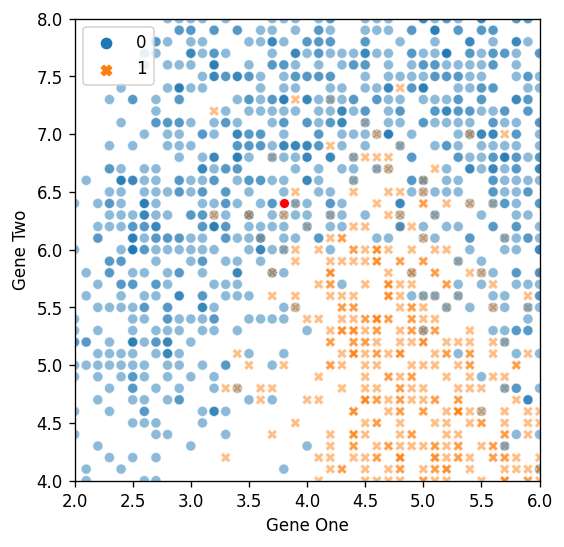

In [42]:
plt.figure(figsize=(5,5), dpi=120)
sns.scatterplot(data=genes, x='Gene One', y='Gene Two', hue='Cancer Present', style='Cancer Present', alpha=0.5)
sns.scatterplot(data=new_patient, x='Gene One', y='Gene Two', color='red')

plt.xlim(2, 6)
plt.ylim(4, 8)
plt.show()